In [14]:
import numpy as np
import pandas as pd
from darts import TimeSeries,concatenate
from darts.models import TFTModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
from captum.attr import IntegratedGradients, NoiseTunnel
import json
import matplotlib.pyplot as plt

In [15]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

df = pd.read_csv("data/ground_station_clean.csv")

In [16]:
encoders = {
    "cyclic":{
        "past":["month","dayofyear","day","hour","minute"],
        "future":["month","dayofyear","day","hour","minute"],
    },
    "transformer": Scaler()
}

In [17]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = TFTModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=60,
        output_chunk_length=40,
        hidden_size=222,
        n_epochs=30, # Considere tornar n_epochs um hiperparâmetro ou usar um valor maior com EarlyStopping
        batch_size=43,
        lstm_layers=1,
        num_attention_heads=4,
        hidden_continuous_size=25,
        add_relative_index=True,
        dropout=0.3,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,    
        show_warnings=True,
        force_reset=True, # Importante para que cada iteração treine do zero com este model_name
        optimizer_kwargs={"lr": 3.1e-4, "weight_decay": 1e-5},
    )

    model.fit(
        series=[train_scaled],
        val_series=val_scaled,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        train_scaled,
        start=0.8,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(train_scaled).split_after(0.8)[1]
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | HuberLoss                        | 0      | train
1  | train_criterion                   | HuberLoss                        | 0      | train
2  | val_criterion                     | HuberLoss                        | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | input_embeddings                  | _MultiEmbedding                  | 0      | train
6  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
7  | encoder_vsn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.045


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.034


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.034. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    10.810062    3.287866    2.688407   
Precipitation_accumulated       0.024276    0.155806    0.137181   
Humidity                      101.119723   10.055830    8.141110   
Wind_Speed_kmh                  0.624122    0.790014    0.628823   
Soil_Moisture              100431.164286  316.908763  246.403630   
Soil_Temperature               22.487065    4.742053    3.559269   
Wind_Dir_Sin                    0.243931    0.493894    0.372038   
Wind_Dir_Cos                    0.235289    0.485066    0.389081   

                                     R2      SMAPE  
Temperature                7.893362e-01  13.273860  
Precipitation_accumulated -2.332905e+07   5.206558  
Humidity                   6.834757e-01  17.484546  
Wind_Speed_kmh            -1.868020e-02  39.820177  
Soil_Moisture              5.887

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | HuberLoss                        | 0      | train
1  | train_criterion                   | HuberLoss                        | 0      | train
2  | val_criterion                     | HuberLoss                        | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | input_embeddings                  | _MultiEmbedding                  | 0      | train
6  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
7  | encoder_vsn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 6.487


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 6.487. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     6.256695    2.501339    2.035207  0.825993   
Precipitation_accumulated       0.599238    0.774105    0.436958  0.466004   
Humidity                       88.256291    9.394482    7.425068  0.711960   
Wind_Speed_kmh                  0.262465    0.512313    0.402765  0.360666   
Soil_Moisture              102864.526855  320.725002  228.211573  0.876640   
Soil_Temperature                8.823103    2.970371    2.365447  0.807966   
Wind_Dir_Sin                    0.307241    0.554293    0.448638  0.116819   
Wind_Dir_Cos                    0.182256    0.426914    0.304085  0.412629   

                                SMAPE  
Temperature                 14.426868  
Precipitation_accumulated   10.283373  
Humidity                    10.702162  
Wind_Speed_kmh              49.358065  
Soil_Mo

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | HuberLoss                        | 0      | train
1  | train_criterion                   | HuberLoss                        | 0      | train
2  | val_criterion                     | HuberLoss                        | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | input_embeddings                  | _MultiEmbedding                  | 0      | train
6  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
7  | encoder_vsn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.085


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0.001. New best score: 0.050


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.036


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.026


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.021


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                   11.961915    3.458600    2.618527      0.553996   
Precipitation_accumulated    367.176552   19.161851   13.616464 -14567.666991   
Humidity                      34.970891    5.913619    4.666642      0.543202   
Wind_Speed_kmh                 0.033554    0.183176    0.138372      0.503217   
Soil_Moisture              67618.447058  260.035473  170.789880      0.636039   
Soil_Temperature              13.268995    3.642663    2.811130      0.537226   
Wind_Dir_Sin                   0.018308    0.135306    0.090875      0.788836   
Wind_Dir_Cos                   0.050303    0.224282    0.098577      0.762777   

                                SMAPE  
Temperature                 16.578359  
Precipitation_accumulated    2.893444  
Humidity                     5.605660  
Wind_Speed_kmh      


   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | HuberLoss                        | 0      | train
1  | train_criterion                   | HuberLoss                        | 0      | train
2  | val_criterion                     | HuberLoss                        | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | input_embeddings                  | _MultiEmbedding                  | 0      | train
6  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
7  | encoder_vsn                       | _VariableSelectionNetwork        | 436 K  | train
8  | decoder_vsn                       | _VariableSelectionNetwork        | 159 K  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.003. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Docum

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE            R2  \
Temperature                   1.905302   1.380327   1.156324  4.216367e-01   
Precipitation_accumulated    61.672058   7.853156   6.290083 -1.124743e+06   
Humidity                     13.404173   3.661171   3.008288 -1.217493e-01   
Wind_Speed_kmh                0.007062   0.084035   0.075309          -inf   
Soil_Moisture              9344.590581  96.667423  86.407956 -5.884184e+00   
Soil_Temperature              2.863639   1.692229   1.467875  9.919683e-02   
Wind_Dir_Sin                  0.001693   0.041151   0.036753          -inf   
Wind_Dir_Cos                  0.001787   0.042276   0.039306          -inf   

                                SMAPE  
Temperature                  8.468902  
Precipitation_accumulated    1.359771  
Humidity                     3.399921  
Wind_Speed_kmh             200.000000  
Soil_Mo


   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | HuberLoss                        | 0      | train
1  | train_criterion                   | HuberLoss                        | 0      | train
2  | val_criterion                     | HuberLoss                        | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | input_embeddings                  | _MultiEmbedding                  | 0      | train
6  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
7  | encoder_vsn                       | _VariableSelectionNetwork        | 436 K  | train
8  | decoder_vsn                       | _VariableSelectionNetwork        | 159 K  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.004. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Docum

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    0.852771    0.923456    0.749595    -0.439989   
Precipitation_accumulated     58.367706    7.639876    7.108895 -1778.009552   
Humidity                       7.897653    2.810276    2.269743     0.172219   
Wind_Speed_kmh                 0.003103    0.055703    0.045104         -inf   
Soil_Moisture              20002.982669  141.431901  119.839791     0.460261   
Soil_Temperature               0.870306    0.932902    0.773591    -2.562585   
Wind_Dir_Sin                   0.000415    0.020363    0.016721         -inf   
Wind_Dir_Cos                   0.001479    0.038460    0.033891         -inf   

                                SMAPE  
Temperature                  7.663974  
Precipitation_accumulated    1.537109  
Humidity                     2.512823  
Wind_Speed_kmh             20


   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | HuberLoss                        | 0      | train
1  | train_criterion                   | HuberLoss                        | 0      | train
2  | val_criterion                     | HuberLoss                        | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | input_embeddings                  | _MultiEmbedding                  | 0      | train
6  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
7  | encoder_vsn                       | _VariableSelectionNetwork        | 436 K  | train
8  | decoder_vsn                       | _VariableSelectionNetwork        | 159 K  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.047


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.047. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE         R2  \
Temperature                    1.006181    1.003086    0.785454   0.606838   
Precipitation_accumulated     15.905861    3.988215    3.526953 -64.620513   
Humidity                      24.196313    4.918975    4.211925   0.518276   
Wind_Speed_kmh                 0.006939    0.083303    0.066301  -3.123275   
Soil_Moisture              17970.412537  134.053767  105.453373  -0.305448   
Soil_Temperature               0.584239    0.764355    0.594964   0.675530   
Wind_Dir_Sin                   0.043886    0.209491    0.078397   0.078959   
Wind_Dir_Cos                   0.068530    0.261783    0.091718   0.054758   

                                SMAPE  
Temperature                 11.224909  
Precipitation_accumulated    0.764912  
Humidity                     4.955659  
Wind_Speed_kmh             192.619833  
Soil_Mo

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | HuberLoss                        | 0      | train
1  | train_criterion                   | HuberLoss                        | 0      | train
2  | val_criterion                     | HuberLoss                        | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | input_embeddings                  | _MultiEmbedding                  | 0      | train
6  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
7  | encoder_vsn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.049


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.041


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.037


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.037. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     3.955127    1.988750    1.547214    0.454405   
Precipitation_accumulated     534.443802   23.118041   18.728543 -254.164358   
Humidity                       56.508544    7.517216    6.476699    0.503979   
Wind_Speed_kmh                  0.782831    0.884778    0.638262    0.420348   
Soil_Moisture              150933.085149  388.501075  280.607682    0.915644   
Soil_Temperature                2.028062    1.424101    1.147583    0.615232   
Wind_Dir_Sin                    0.290889    0.539341    0.424174    0.232242   
Wind_Dir_Cos                    0.275301    0.524691    0.396460    0.458233   

                                SMAPE  
Temperature                 37.336263  
Precipitation_accumulated    4.112487  
Humidity                     7.592677  
Wind_Speed_kmh             12

In [18]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

TFTModel(output_chunk_shift=0, hidden_size=222, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.3, hidden_continuous_size=25, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=HuberLoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=True, model_name=model_2, input_chunk_length=60, output_chunk_length=40, n_epochs=30, batch_size=43, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fb5083b9880>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.00031, 'weight_decay': 1e

In [19]:
s = scaler.inverse_transform(best_train_scaled).split_after(0.8)[1]
forecasts_t = scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


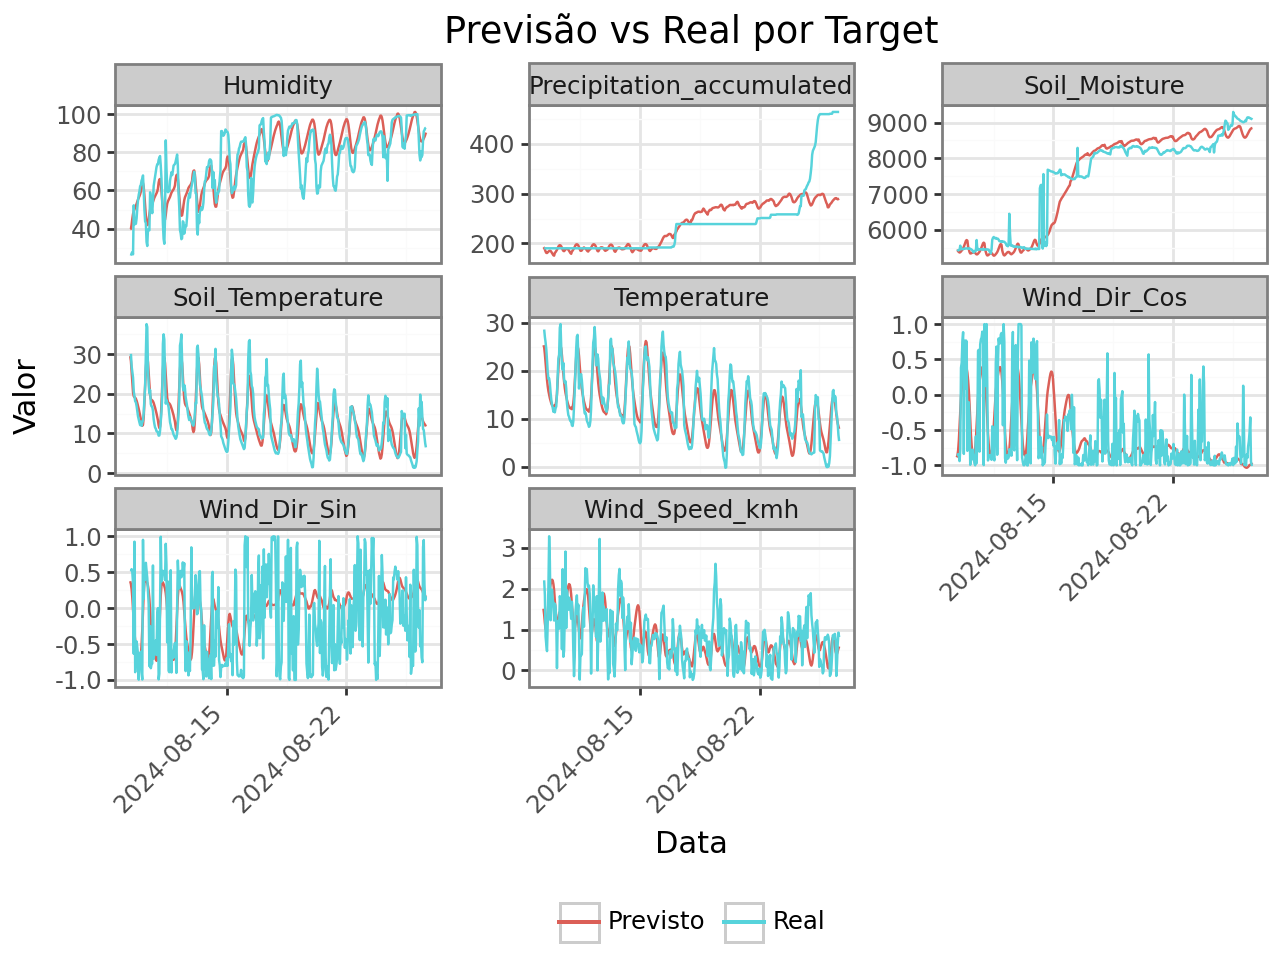

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_vs_real.png


In [20]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Real'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Previsto'

# Concatena os DataFrames 'Real' e 'Previsto'
df_combined = pd.concat([s_melted, forecasts_t_melted])

# Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão vs Real por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
    )
)
plot.show()
plot.save('previsao_vs_real.png', width=12, height=10, dpi=300)

In [21]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

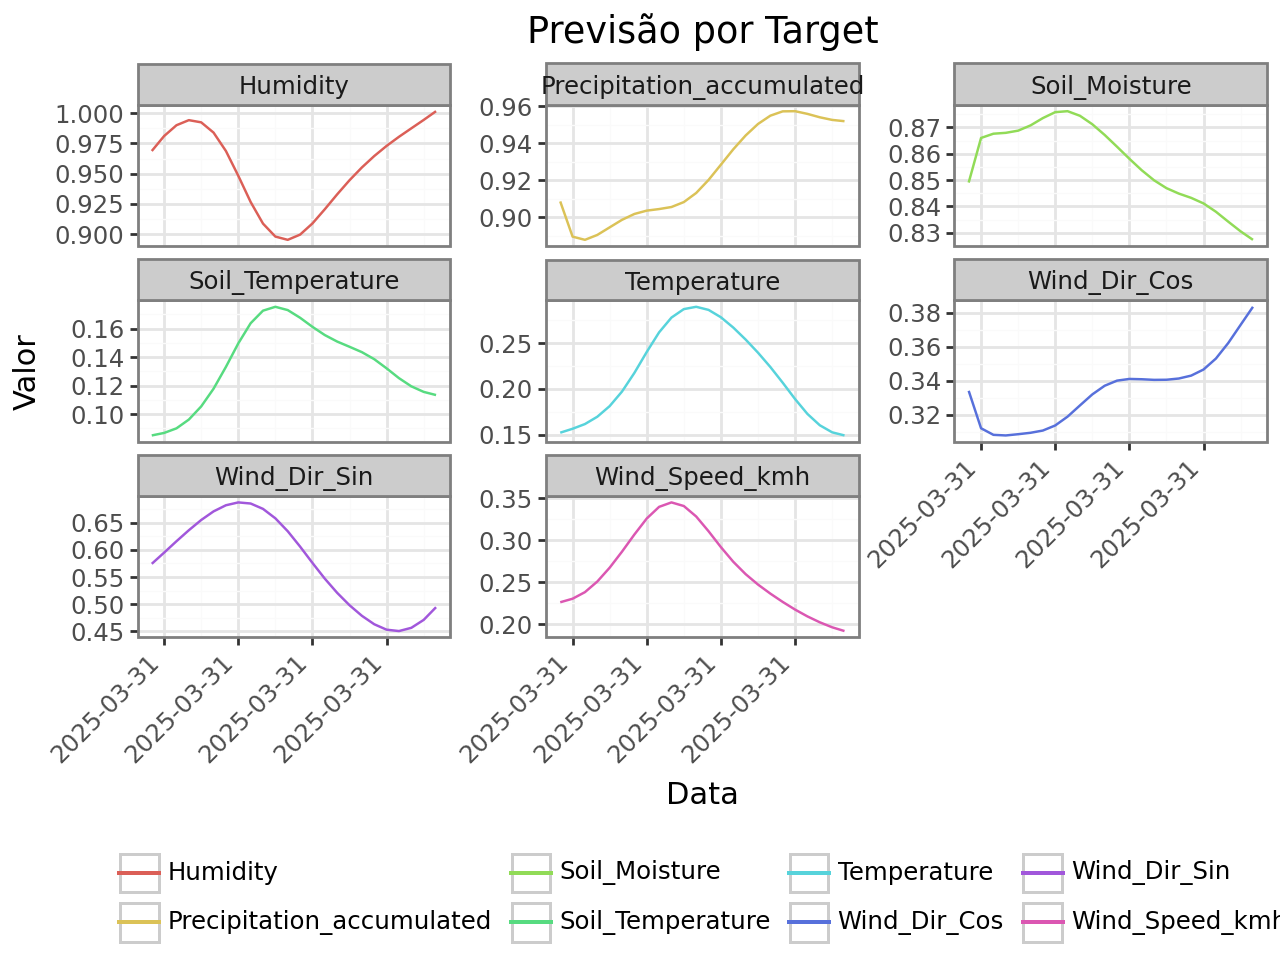

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_24_horas.png


In [22]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
        
    )
)
plot.show()
plot.save('previsao_24_horas.png', width=12, height=10, dpi=300)

In [23]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

In [24]:
# prepara série-alvo e covariáveis
tgt_arr = best_val_scaled[0].values()
encoder_values = model.generate_fit_encodings(best_train_scaled)
cov_arr = encoder_values[0][0].values()  # use seu objeto de covariáveis reais

params = next(model.model.parameters())
dtype, device = params.dtype, params.device

tgt = torch.tensor(tgt_arr, dtype=dtype, device=device).unsqueeze(0)
cov = torch.tensor(cov_arr, dtype=dtype, device=device).unsqueeze(0)

full_input = torch.cat([tgt, cov], dim=2)
full_input.requires_grad_(True)
baseline = torch.zeros_like(full_input)

def forward_fn(x):
    preds,_ = model.model((x, None))
    return preds[:, -1, 0]

ig = IntegratedGradients(forward_fn)
attrs, delta = ig.attribute(
    inputs=full_input,
    baselines=baseline,
    return_convergence_delta=True
)
ig_vals = attrs.detach().cpu().numpy()[0].sum(axis=0)
print("IG importâncias:", ig_vals, "δ=", delta)

nt = NoiseTunnel(ig)
nt_attrs = nt.attribute(
    inputs=full_input,
    baselines=baseline,
    nt_type='smoothgrad',
    nt_samples=10,
    stdevs=0.02
)
nt_vals = nt_attrs.detach().cpu().numpy()[0].sum(axis=0)
print("NT importâncias:", nt_vals)


ValueError: not enough values to unpack (expected 3, got 2)

In [36]:
target_names = best_val_scaled[0].columns.tolist()
covar_names  = encoder_values[0][0].columns.tolist()
feature_names = target_names + covar_names

# monta DataFrame
df = pd.DataFrame({
    "feature": feature_names,
    "IG": ig_vals,
    "NT": nt_vals,
}).melt(id_vars="feature", var_name="method", value_name="importance")

plot = (
    ggplot(df, aes(x="feature", y="importance", fill="method"))
    + geom_col(position="dodge")
    + coord_flip()                          # faz o flip para ficar horizontal
    + labs(x="Feature", y="Importância", fill="Método",
           title="Importância de Features pelo IG e NT")
    + theme_bw()
)

plot.show()
plot.save('importancia_features.png', width=12, height=10, dpi=300)

NameError: name 'ig_vals' is not defined